# Student Intervention - Project 2

In [5]:
%matplotlib inline

Import libraries

In [6]:
import numpy as np
import pandas as pd
import csv
import time
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split, KFold
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import classification_report

# First, decide how many training vs test samples you want
from sklearn.cross_validation import train_test_split

import pylab as pl
import matplotlib.pyplot as pl
from sklearn.preprocessing import scale
from ggplot import *
from sklearn import metrics

pl.style.use('fivethirtyeight')
import seaborn as sns

In [7]:
student_data = pd.read_csv("student-data.csv")
print ("Student data read successfully!")


Student data read successfully!


In [8]:
student_data.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

   ...   internet romantic  famrel  freetime  goout Dalc Walc health absences  \
0  ...         no       no       4         3      4    1    1      3        6   
1  ...        yes       no       5         3      3    1    1      3        4   
2  ...        yes       no       4         3      2    2    3      3       10   
3  ...        yes      yes       3         2      2    1    1      5        2   
4  ...         no       no       4         3      2    1    2      5        4   

  passed  
0     no  
1     no  
2    yes  
3    yes  
4    yes  

[5 rows x 31 columns]

In [9]:
n_students = student_data.shape[0]
n_features = student_data.shape[1]-1
n_passed =  student_data[student_data['passed'] =='yes'].shape[0]
n_failed =  student_data[student_data['passed'] == 'no'].shape[0]
grad_rate = (n_passed*1.0) / (n_students*1.0) * 100
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(float(grad_rate))

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


In [10]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
#print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed


In [11]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [12]:
#Format Target yes/no values with 1/0
y = pd.DataFrame(y_all, index = y_all.index)
y = y.replace(['yes', 'no'], [1, 0])
#in the form (X, 1), but the method expects a 1d array and has to be in the form (X, )

#join dataset
df_data = pd.concat([X_all, y], axis = 1)
df1 = df_data.describe()
print(df1.unstack())

#Data Correlation:
df = df_data.corr()
corr_target = df.ix[-1][:-1] #Target is last column in the DataFrame
predict = corr_target.sort_values(ascending=False)
df_sort = corr_target.sort_values(ascending=False)
#print df_sort

school_GP  count    395.000000
           mean       0.883544
           std        0.321177
           min        0.000000
           25%        1.000000
           50%        1.000000
           75%        1.000000
           max        1.000000
school_MS  count    395.000000
           mean       0.116456
           std        0.321177
           min        0.000000
           25%        0.000000
           50%        0.000000
           75%        0.000000
           max        1.000000
sex_F      count    395.000000
           mean       0.526582
           std        0.499926
           min        0.000000
           25%        0.000000
           50%        1.000000
           75%        1.000000
           max        1.000000
sex_M      count    395.000000
           mean       0.473418
           std        0.499926
           min        0.000000
           25%        0.000000
           50%        0.000000
                       ...    
Walc       std        1.287897
        

In [13]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

y = student_data['passed']
#print y

def Stratified_Shuffle_Split(X,y,num_test):
    sss = StratifiedShuffleSplit(y, 1, test_size=num_test, random_state = None)
    for train_index, test_index in sss:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)
print "Training Set: {0:.2f} Samples".format(X_train.shape[0])
print "Testing Set: {0:.2f} Samples".format(X_test.shape[0])

Training Set: 300.00 Samples
Testing Set: 95.00 Samples


Train Model

In [14]:
def train_classifier(clf, X_train, y_train):
    print "Training {}:".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    train_clf_time = end - start
    print "Training Time (secs): {:.3f}".format(train_clf_time)
    return train_clf_time

Predict on Training Set and Compute F1 Score

In [15]:
def predict_labels(clf, features, target):
    print "Predicting labels using {}:".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    prediction_time = end - start
    print "Prediction Time (secs): {:.3f}".format(prediction_time)
    
    p,r,f,s = precision_recall_fscore_support(target.values, y_pred, average='binary', pos_label='yes')
    print "Precision Score: {0:.4f}".format(p)
    print "Recall Score: {0:.4f}".format(r)
    print "F1 Score: {0:.4f}".format(f)
    #"Macro": Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

Train and Predict Using Different Training Set Sizes:

In [16]:
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_diff = train_classifier(clf, X_train, y_train)
    
    # Train and predict on diff. training set sizes
    f1_score_train, pred_time_train = predict_labels(clf, X_train, y_train)
    print "F1 score for training set:",(f1_score_train)
    
    # Predict on test data
    f1_score_test, pred_time_test = predict_labels(clf, X_test, y_test)
    print "F1 score for test set:",(f1_score_test)
    
    return (f1_score_train, f1_score_test, train_diff, pred_time_test)


# Model 1: Naive Bayes

In [17]:
#Predict on Training Data
clf_NB = GaussianNB()

print"Training:"
print "Testing Data Size:",len(X_train)
# Fit model to training data
train_classifier(clf_NB, X_train, y_train)

# Predict on training set and compute F1 score
trainin_score = predict_labels(clf_NB, X_train, y_train)

#Predict on Testing Data
print "**********************************************************"
print "Testing:"
print "Testing Data Size:",len(X_test)
testing_score = predict_labels(clf_NB, X_test, y_test)



Training:
Testing Data Size: 300
Training GaussianNB:
Training Time (secs): 0.004
Predicting labels using GaussianNB:
Prediction Time (secs): 0.002
Precision Score: 0.7961
Recall Score: 0.8159
F1 Score: 0.8059
**********************************************************
Testing:
Testing Data Size: 95
Predicting labels using GaussianNB:
Prediction Time (secs): 0.001
Precision Score: 0.7077
Recall Score: 0.7188
F1 Score: 0.7132


# Model 2: SVC

In [18]:
#Predict on Training Data
clf_SVC = SVC()

print"Training:"
print "Testing Data Size:",len(X_train)
# Fit model to training data
train_classifier(clf_SVC, X_train, y_train)

# Predict on training set and compute F1 score
trainin_score = predict_labels(clf_SVC, X_train, y_train)

#Predict on Testing Data
print "**********************************************************"
print "Testing:"
print "Testing Data Size:",len(X_test)
testing_score = predict_labels(clf_SVC, X_test, y_test)


Training:
Testing Data Size: 300
Training SVC:
Training Time (secs): 0.014
Predicting labels using SVC:
Prediction Time (secs): 0.008
Precision Score: 0.7634
Recall Score: 0.9950
F1 Score: 0.8639
**********************************************************
Testing:
Testing Data Size: 95
Predicting labels using SVC:
Prediction Time (secs): 0.003
Precision Score: 0.6977
Recall Score: 0.9375
F1 Score: 0.8000


# Model 3: Random Forest

Training:
Testing Data Size: 300
Training RandomForestClassifier:
Training Time (secs): 0.443
Predicting labels using RandomForestClassifier:
Prediction Time (secs): 0.019
Precision Score: 1.0000
Recall Score: 1.0000
F1 Score: 1.0000
**********************************************************
Testing:
Testing Data Size: 95
Predicting labels using RandomForestClassifier:
Prediction Time (secs): 0.013
Precision Score: 0.7089
Recall Score: 0.8750
F1 Score: 0.7832


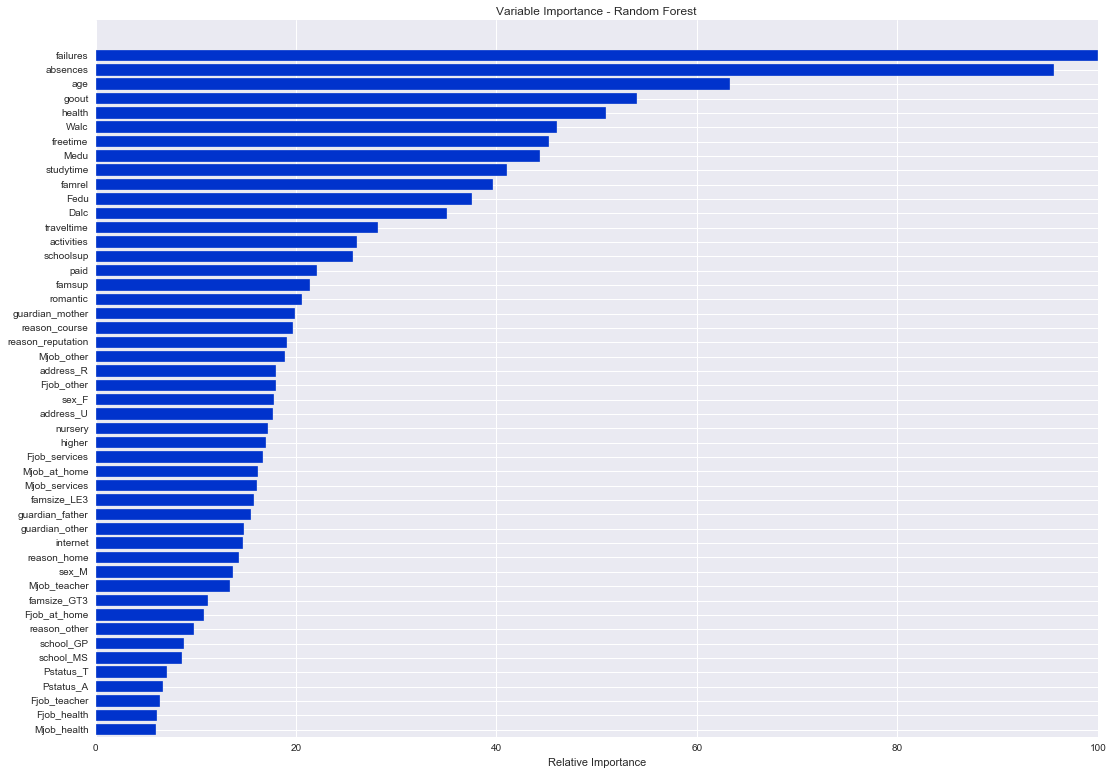

In [19]:
#Predict on Training Data
clf_RF = RandomForestClassifier(n_estimators = 100)

print"Training:"
print "Testing Data Size:",len(X_train)
# Fit model to training data
train_classifier(clf_RF, X_train, y_train)

# Predict on training set and compute F1 score
trainin_score = predict_labels(clf_RF, X_train, y_train)


#Predict on Testing Data
print "**********************************************************"
print "Testing:"
print "Testing Data Size:",len(X_test)
testing_score = predict_labels(clf_RF, X_test, y_test)

# Relative Importance (Features)
clf_RF.fit(X_train,y_train)
# Get Feature Importance from the classifier
feature_importance = clf_RF.feature_importances_
# Normalize The Features
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# Sort Features and Creat Horizontal Bar Plot
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pl.figure(figsize=(16, 12))
pl.barh(pos, feature_importance[sorted_idx], align='center', color='#0033CC')
pl.yticks(pos, np.asanyarray(df.columns.tolist())[sorted_idx])
pl.xlabel("Relative Importance")
pl.title("Variable Importance - Random Forest")
pl.show()


# Fine Tune Model:

In [20]:
# Fine-tune the model and report the best F1 score

# Reformat "Y" from 'yes/no' to '1/0'
def reformat(col_data):
    return col_data.replace(['yes', 'no'], [1, 0])

def iterate_fit_predict(number_runs):
        f1_scores = []
        gamma = []
        C = []

        y = reformat(student_data['passed'])
        
        for num in range(0,number_runs):
            X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)
            clf_SVC = SVC()
            parameters = [{'C':[1,10,50,100,200,300,400,500,1000],
                         'gamma':[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
                         'kernel': ['rbf']}]
    
            
            clf = GridSearchCV(clf_SVC, parameters, scoring = 'f1')
            
            # Fit the learner to the training data to obtain the best parameter set
            clf.fit(X_train, y_train)
            f1_scores.append(clf.score(X_test, y_test))
            gamma.append(clf.best_params_['gamma'])
            C.append(clf.best_params_['C'])
            clf = clf.best_estimator_
            #print clf
        
        df_f1 = pd.Series(f1_scores)
        df_gamma = pd.Series(gamma)
        df_C = pd.Series(C)
        
        print clf
        print "\nF1 Scores:"
        print df_f1
        print "\nC:"
        print df_C
        print "\nGamma:"
        print df_gamma

        print "\nAverage F1 Test Scores:"
        print df_f1.mean()
        print "\nAverage C:"
        print df_C.mean()
        print "\nAverage Gamma:"
        print df_gamma.mean()
        

In [21]:
iterate_fit_predict(3)

/Library/Python/2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

F1 Scores:
0    0.807947
1    0.810127
2    0.800000
dtype: float64

C:
0    100
1      1
2     10
dtype: int64

Gamma:
0    0.0001
1    0.1000
2    0.0010
dtype: float64

Average F1 Test Scores:
0.806024534049

Average C:
37.0

Average Gamma:
0.0337


# Confusion Matrix

In [33]:
from pandas_confusion import ConfusionMatrix

def iterate_fit_predict_score(number_runs):
        f1_scores = []
        
        y = reformat(student_data['passed'])
        
        for num in range(0,number_runs):
            X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)
            clf_SVC = SVC()
            parameters = [{'C':[1,10,50,100,200,300,400,500,1000],
                         'gamma':[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
                         'kernel': ['rbf']}]
    
            clf = GridSearchCV(clf_SVC, parameters, scoring = 'f1')
            clf.fit(X_train, y_train)
            y_true, y_pred = y_test, clf.predict(X_test)
            target_names = ["failed","passed"]
            print(classification_report(y_true, y_pred,target_names=target_names))    
            
            # Print Conf_Matrix
            conf_matrix = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
            print "\nConf_Matrix:", conf_matrix
            
            #Normalize Conf_Matrix:
            conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)
            print "\nNormalize Conf_Matrix:", conf_matrix_norm
            
            #Generate Confusion Matrix Plot
            conf_matrix = metrics.confusion_matrix(y_true, y_pred)
            labels = ['fail','pass']
            pl.title('SVC: Confusion Matrix')
            ax = pl.axes
            sns.heatmap(conf_matrix, 
                    xticklabels=labels, 
                    yticklabels=labels,
                    annot=True, fmt='')
            pl.xlabel("Predicted")
            pl.ylabel("True")

             precision    recall  f1-score   support

     failed       0.67      0.26      0.37        31
     passed       0.72      0.94      0.82        64

avg / total       0.70      0.72      0.67        95


Conf_Matrix: Predicted   0   1  All
Actual                
0           8  23   31
1           4  60   64
All        12  83   95

Normalize Conf_Matrix: Predicted         0         1       All
Actual                                 
0          0.129032  0.179688  0.163158
1          0.064516  0.468750  0.336842
All        0.193548  0.648438  0.500000


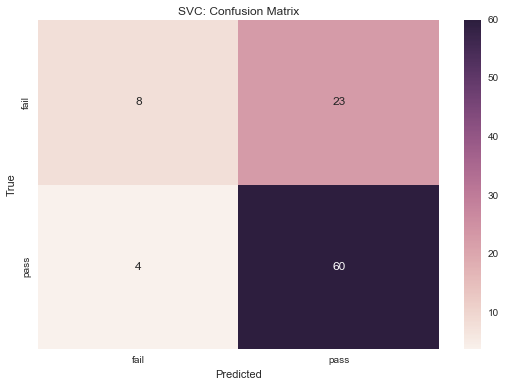

In [34]:
iterate_fit_predict_score(1)

# ROC and AUC

In [205]:
# Support Vector Machines:

def reformat(col_data):
    return col_data.replace(['yes', 'no'], [1, 0])

def iterate_fit_predict_svc(number_runs):
        f1_scores = []
        auc = []

        y = reformat(student_data['passed'])
        
        for num in range(0,number_runs):
            X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)
            clf_SVC = SVC(probability=True)
            parameters = [{'C':[1,10,50,100,200,300,400,500,1000],
                         'gamma':[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
                         'kernel': ['rbf']}]
            
            clf = GridSearchCV(clf_SVC, parameters, scoring = 'f1')
            
            # Fit the learner to the training data to obtain the best parameter set
            clf.fit(X_train, y_train)
            f1_scores.append(clf.score(X_test, y_test))
            clf = clf.best_estimator_
            
            # Generate ROC Curve
            preds = clf.predict_proba(X_test)[:,1]
            fpr, tpr, _ = metrics.roc_curve(y_test, preds)
            df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
            auc_1 = metrics.auc(fpr,tpr)
            auc.append(metrics.auc(fpr,tpr))
            df_auc = pd.DataFrame(auc)
            g1 = ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) +\
            geom_area(alpha=0.1, size=5, colour='green', fill = 'green') +\
            geom_line(aes(y='tpr')) +\
            ggtitle("ROC: Area Under Cuve = %s" % str(auc_1)) 
            print g1
        print "\nAverage Area Under Curve"
        print df_auc.mean()


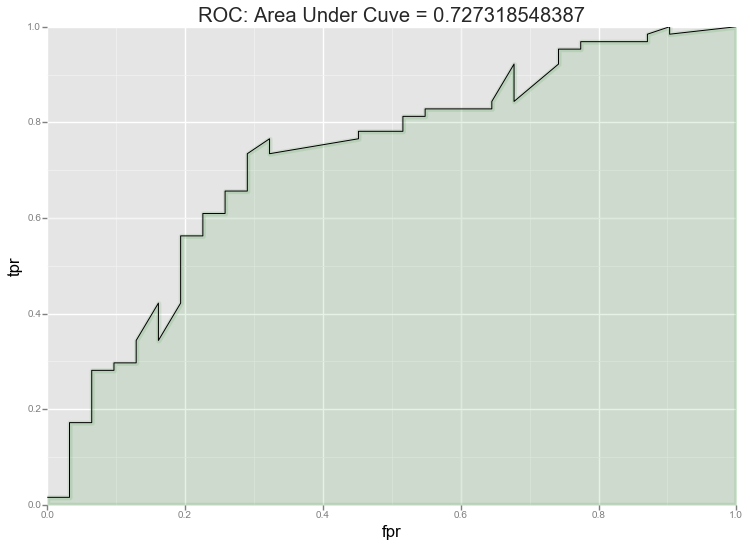

<ggplot: (279092817)>

Average Area Under Curve
0    0.727319
dtype: float64


In [209]:
iterate_fit_predict_svc(1)